In [1]:
import numpy as np

from matplotlib import pyplot as plt

In [2]:
import time
import h5py
import numpy as np
import scipy.io as sio

from scipy import __version__ as scipy_version
if scipy_version >= '1.8':
    from scipy.io.matlab import matfile_version
else:
    from scipy.io.matlab.mio import _open_file
    from scipy.io.matlab.miobase import get_matfile_version


def check_matfile_version(matfile: str):
    if scipy_version >= '1.8':
        return matfile_version(matfile, appendmat=True)[0]
    else:
        return get_matfile_version(_open_file(matfile, appendmat=True)[0])[0]

def load_mat_file(matfile:str):
    '''
    Load dataset from .mat file (MATLAB '-v7.2' or below and '-v7.3')
    '''
    if check_matfile_version(matfile) < 2:
        # for '-v7.2' and lower version of .mat file (MATLAB)
        file = sio.loadmat(matfile)
    else:  # MATLAB .mat v7.3
        file = h5py.File(matfile, 'r')  # for '-v7.3' .mat file (MATLAB)
    return file


def load_dataset_from_mat(matfile:str, images_varname:str='images', labels_varname='labels'):
    '''
    Load dataset (image/label pairs [0]->N) from MATLAB .MAT file
    '''
    start_time = time.time()
    if check_matfile_version(matfile) < 2:
        # for '-v7.2' and lower version of .mat file (MATLAB)
        file = sio.loadmat(matfile)
        images = np.array(file[images_varname])
        labels = np.array(file[labels_varname])
    else:  # MATLAB .mat v7.3
        file = h5py.File(matfile, 'r')  # for '-v7.3' .mat file (MATLAB)
        images = np.transpose(file[images_varname])
        labels = np.transpose(file[labels_varname])
    print('dataset loading elapsed time %.2f seconds. dataset file: %s' %
          ((time.time() - start_time), matfile))
    return images, labels

In [37]:
from PIL import Image
from PIL import ImageDraw

def generate_mask_from_corners(shape, corners):
    '''
    Generate a binary mask from (four) corners where the inside is `1` and 
    the rest is `0`.
    '''
    blank = Image.new('1', shape, 0) # binary PIL image - all 0's
    draw = ImageDraw.Draw(blank)

    corners_draw = [tuple(corners[i]) for i in range(corners.shape[0])]
    draw.polygon(corners_draw, fill='white', outline=None)

    return np.asarray(blank).astype(np.uint8)

def draw_polygon_on_image(image, corner, colormode=False, edgecolor='blue', pointcolor='cyan'):
    if colormode:
        im_pil = Image.fromarray(np.repeat(image[...,np.newaxis],3,axis=-1),'RGB')
    else:
        im_pil = Image.fromarray(image)
    draw = ImageDraw.Draw(im_pil)

    corner_draw = [tuple(corner[i]) for i in range(corner.shape[0])]
    draw.polygon(corner_draw, fill=None, outline=edgecolor)
    draw.point(tuple(corner[0]), fill=pointcolor)
    
    return np.asarray(im_pil)

In [4]:
import cv2

def crop_homography(image, corner, dst_size=[100,100]):
    H, W = dst_size
    pts_dst = np.array([[0,0], [W,0], [W,H], [0,H]])

    # compute homography
    Hmat, status = cv2.findHomography(corner, pts_dst)
    # Hmat, status = cv2.findHomography(corner, pts_dst, method=cv2.LMEDS)

    im_dst = cv2.warpPerspective(image, Hmat, [W,H])

    return im_dst

In [5]:
dataset_path = '/data/yliu/proj/microneedle/data/needle10x10_image120x120_ord_100k_rect.mat'
dataset_path = '/data/yliu/proj/microneedle/data/needle17x17_1k_rect.mat'

images, corners = load_dataset_from_mat(dataset_path, 'images_raw', 'corners')

dataset loading elapsed time 1.84 seconds. dataset file: /data/yliu/proj/microneedle/data/needle17x17_1k_rect.mat


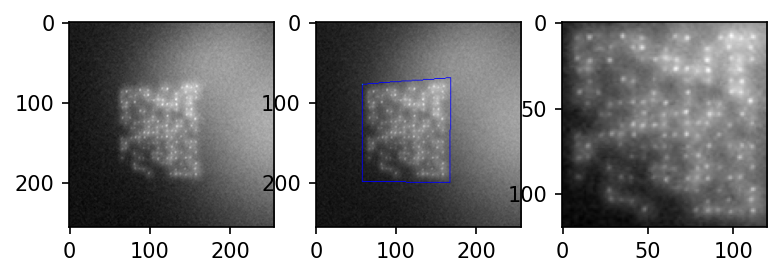

In [8]:
idx = 515
reorder = False
dst_size = [120,120]

topleft_idx = np.argmin(np.sum(corners,axis=2), axis=1)

image  = images[idx]
corner = corners[idx]

if reorder:
    k = topleft_idx[idx]
    corner = corner[np.arange(k,k+4)%4]

corner = corner * image.shape # relative -> absolute

image_poly = draw_polygon_on_image(image, corner, colormode=True)
image_crop = crop_homography(image, corner, dst_size)

plt.figure(dpi=150)
plt.subplot(131)
plt.imshow(image,cmap='gray')
plt.subplot(132)
plt.imshow(image_poly,cmap='gray')
plt.subplot(133)
plt.imshow(image_crop,cmap='gray')
plt.show()

In [18]:
dataset_path = '/data/yliu/proj/microneedle/data/needle17x17_1k_bin.mat'

_, images_bin = load_dataset_from_mat(dataset_path, 'images_raw', 'images_bin')

uint8 uint8


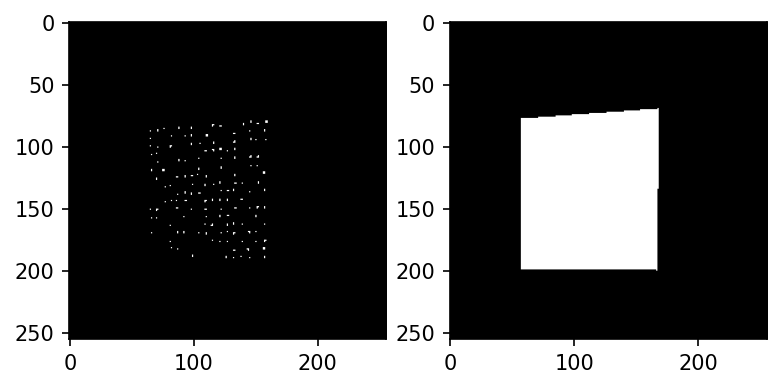

In [38]:
image_bin = images_bin[idx]

mask = generate_mask_from_corners(image.shape, corner)

print(image_bin.dtype,mask.dtype)

plt.figure(dpi=150)
plt.subplot(121)
plt.imshow(image_bin,cmap='gray')
plt.subplot(122)
plt.imshow(mask,cmap='gray')
plt.show()

In [39]:
print(image_bin.min(), image_bin.max())
print(image.shape)
print(mask.min(), mask.max())
print(mask.shape)

0 1
(256, 256)
0 1
(256, 256)
